# Doublet Analysis

Project ArchR Doublet scores over UMAP with all cells (no doublet removal) to estimate doublet population.

In [9]:
library(GenomicRanges)
library(ggplot2)
library(scales)

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
doublet_scores = data.frame(sample_barcode=c(), score=c())

# no doublet scores for D0 as it is a homogenous population
for (d in c("D2", "D4", "D6", "D8", "D10", "D12", "D14")) {
    cur_rds = readRDS(sprintf("./QualityControl/%s/%s-Doublet-Summary.rds", d, d))
    cur_doublet_scores = cur_rds$doubletResults$doubletScoreUMAP
    cur_doublet_scores = data.frame(sample_barcode=sub("#", "_", names(cur_doublet_scores)), 
                                    score=cur_doublet_scores)
    
    doublet_scores = rbind(doublet_scores, cur_doublet_scores)
}

rownames(doublet_scores) = doublet_scores$sample_barcode
doublet_scores$sample_barcode = NULL

In [5]:
head(doublet_scores)

,score
,<dbl>
D2_ATCGAGACTGTGGTGA,6.658828
D2_CCCGACAGATGTTGTG,14.591094
D2_CAGGCTTCTCTCATTT,2.150883
D2_TCGCCGAGAGCTCTTC,5.674139
D2_AAGTTTCCTCTATCTT,2.417885
D2_TAGCTCGCTGCGGTTC,0.000000


In [6]:
dscores = doublet_scores[rownames(metaData), "score"]
dscores[is.na(dscores)] = 0

In [7]:
quantile(dscores, 0.95)

95% 
23.51846

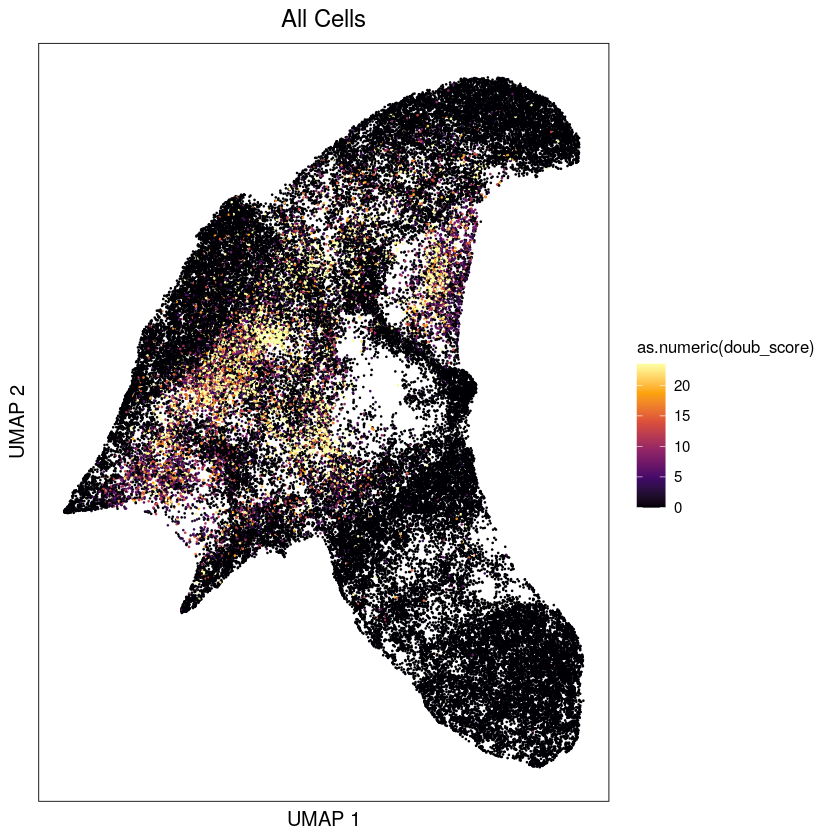

In [13]:
df = data.frame(metaData, doub_score=dscores)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(dscores, 0.05), 
                               quantile(dscores, 0.95)), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle("All Cells") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

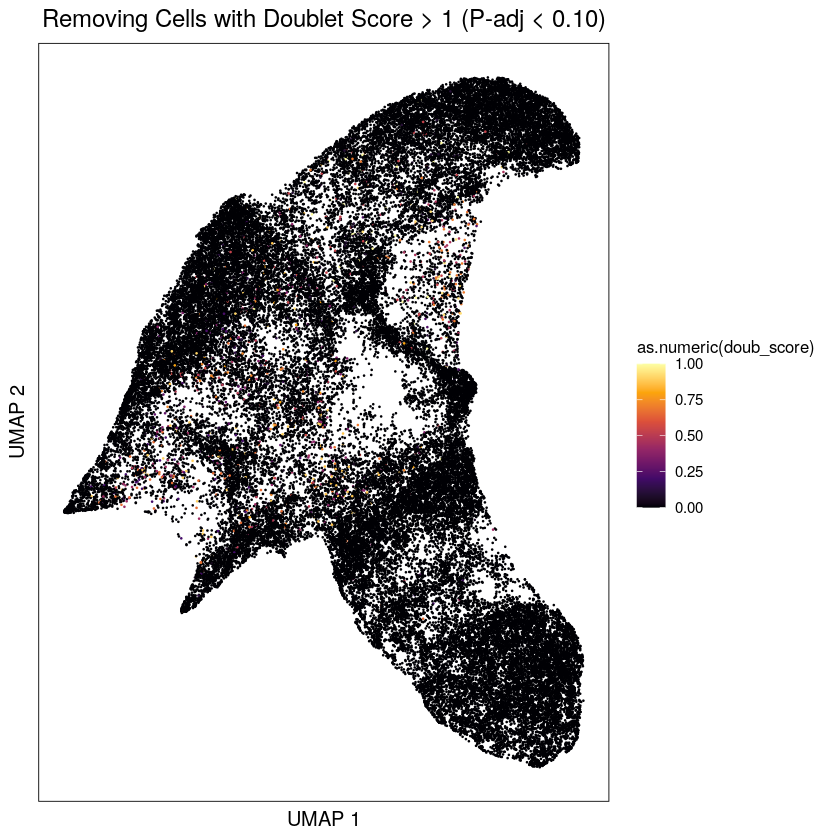

In [29]:
CUTOFF = 1
df = data.frame(metaData[dscores<=CUTOFF,], doub_score=dscores[dscores<=CUTOFF])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, CUTOFF), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle(sprintf("Removing Cells with Doublet Score > %d (P-adj < %.2f)", CUTOFF, 10^(-CUTOFF))) +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [52]:
sum(dscores<=1)

[1] 56869

In [59]:
# write barcodes with zero doublet score (most stringent) for replotting UMAP
for (x in unique(metaData$sample)) {
    cur_barcodes = metaData[(metaData$sample==x)&(dscores==0), "barcode"]
    write.table(unlist(cur_barcodes),
                sprintf("../20200206_pmat_snapATAC/barcodeLists/20200531_ArchR_doublet_score_0/%s.barcodes.txt", x), 
                row.names=F,
                col.names=F,
                quote=F)
}